### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note:
this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/HPLC/"
DIN_acs = "/data/datasets/cruise_data/active/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/"

In [6]:
# read HPLC data
fn_hplc = "Dall'Olmo 10-03 report.xlsx"
df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "Report", header = 8, engine = 'openpyxl',
                        nrows = 247, usecols = range(63))

# correct exceptions
i2corr0 = np.where(df_hplc.time.values==12243)
df_hplc.time.loc[i2corr0] = 1224
# print(df_hplc.time.values[i2corr0])

i2corr1 = np.where(df_hplc.time.values==7320)
df_hplc.time.loc[i2corr1] = 1320
# print(df_hplc.time.values[i2corr1])


# format date fields
day = [f'{i:02}' for i in df_hplc.day.values]
time = [f'{i:04}' for i in df_hplc.time.values]
hh = [i[0:2] for i in time]
mm = [i[2:4] for i in time]

# create date string 
tmp_date = [df_hplc["year"].values.astype(str)[i] + "-" +
            df_hplc["month"].values.astype(str)[i] + "-" +
            day[i] + " " +
            hh[i] + ":" +
            mm[i] 
                        for i in range(len(mm))]

df_hplc['time'] = pd.to_datetime(tmp_date)
                       
df_hplc = df_hplc.sort_values(by=['time'])
df_hplc = df_hplc.reset_index(drop=True)

# invert names of columns lat and lon (bc they were wrongly written)
df_hplc = df_hplc.rename(columns={"lat": "lon", "lon": "lat"})

# set time as index
# df_hplc.month
# pd.to_datetime((df_hplc[['year', 'month', 'day']]).apply(str), format = '%Y%b%d')
# pd.to_datetime(df_hplc[['year', 'month', 'day']], format = "%Y")
# [df_hplc['year'].values, df_hplc['month'].values, df_hplc['day'].values]
# df_hplc

/users/modellers/gdal/miniconda3/envs/OLTraj/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/users/modellers/gdal/miniconda3/envs/OLTraj/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# clean up lat
tmpla = df_hplc['lat'].values
for i,la in enumerate(tmpla):
    if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        degrees = float(la.split("°")[0]) 
        minutes = float(la.split("°")[-1].split("'")[0])
        NoS = la.split("°")[-1].split("'")[-1]
        sign = -1
        if (NoS.upper() == "N"):
            sign = 1
        df_hplc.at[i, 'lat'] = sign*(degrees + minutes/60.)

# clean up lon
tmplo = df_hplc['lon'].values
for i,lo in enumerate(tmplo):
    if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        degrees = float(lo.split("°")[0]) 
        minutes = float(lo.split("°")[-1].split("'")[0])
        EoW = lo.split("°")[-1].split("'")[-1]
        sign = -1
        if (EoW.upper() == "E"):
            sign = 1
        df_hplc.at[i, 'lon'] = sign*(degrees + minutes/60.)


In [8]:
# extract surface data
isurf = (df_hplc["depth"]<10) | (df_hplc["bottle"]=="UW")
df_hplc_surf = df_hplc[isurf]
df_hplc_surf = df_hplc_surf.set_index("time")
# df_hplc_surf



In [9]:
# read ACS data
fn_acs = "amt29_final.nc"
acs = xr.open_dataset(DIN_acs+fn_acs)
acs.close()


In [10]:
df_hplc.keys()

Index(['hplc_gsfc_id', 'PI', 'sample', 'cruise',
       'indicate if filters are replicates', 'volfilt', 'station', 'bottle',
       'depth', 'water_depth', 'name of water body', 'year', 'month', 'day',
       'sdy', 'time', 'lat', 'lon', 'filter type', 'filter diameter (mm)',
       'filter storage before shipment to GFC', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl c1c2', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'Tchl', 'PPC', 'PSC',
       'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP', 'Tacc_Tchla', 'PSC_Tcar',
       'PPC_Tcar', 'Tchl_Tcar', 'PPC_Tpg', 'PSP_Tpg', 'Tchl a_Tpg',
       'comments'],
      dtype='object')

### Add HPLC data to NetCDF file

In [11]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc.time, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [12]:
df_hplc.keys()

Index(['hplc_gsfc_id', 'PI', 'sample', 'cruise',
       'indicate if filters are replicates', 'volfilt', 'station', 'bottle',
       'depth', 'water_depth', 'name of water body', 'year', 'month', 'day',
       'sdy', 'time', 'lat', 'lon', 'filter type', 'filter diameter (mm)',
       'filter storage before shipment to GFC', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl c1c2', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'Tchl', 'PPC', 'PSC',
       'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP', 'Tacc_Tchla', 'PSC_Tcar',
       'PPC_Tcar', 'Tchl_Tcar', 'PPC_Tpg', 'PSP_Tpg', 'Tchl a_Tpg',
       'comments'],
      dtype='object')

In [13]:
#### read HPLC metadata on pigments
hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
                        nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# shift info around in original table
df1 = hplc_pignm.iloc[:, [0,1,2]]
df2 = hplc_pignm.iloc[:, [3,4,5]] 
df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
                     df2.keys()[1]: 'name',
                     df2.keys()[2]: 'notes'
                    })
df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
                     df1.keys()[1]: 'name',
                     df1.keys()[2]: 'notes'
                    })
# concatenate to subsets of attributes
df1 = df1.append(df2, ignore_index=True)

# find indices with empty abbreviations and drop them
ind = []
for irow in range(len(df1['abbreviation'].values)):
    if type(df1['abbreviation'].values[irow])==float:
        ind.append(irow)
    
df_hplc_pignm = df1.drop(ind)    


In [14]:
df_hplc.keys()

Index(['hplc_gsfc_id', 'PI', 'sample', 'cruise',
       'indicate if filters are replicates', 'volfilt', 'station', 'bottle',
       'depth', 'water_depth', 'name of water body', 'year', 'month', 'day',
       'sdy', 'time', 'lat', 'lon', 'filter type', 'filter diameter (mm)',
       'filter storage before shipment to GFC', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl c1c2', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'Tchl', 'PPC', 'PSC',
       'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP', 'Tacc_Tchla', 'PSC_Tcar',
       'PPC_Tcar', 'Tchl_Tcar', 'PPC_Tpg', 'PSP_Tpg', 'Tchl a_Tpg',
       'comments'],
      dtype='object')

In [15]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [16]:
### add HPLC variables to acs dataset
# drop time-related columns
if 'year' in df_hplc.keys():
    df_hplc = df_hplc.drop(columns=['year', 'month', 'day', 'sdy', 'time',
                               'water_depth', 'name of water body' ])


In [17]:
df_hplc.keys()

Index(['hplc_gsfc_id', 'PI', 'sample', 'cruise',
       'indicate if filters are replicates', 'volfilt', 'station', 'bottle',
       'depth', 'lat', 'lon', 'filter type', 'filter diameter (mm)',
       'filter storage before shipment to GFC', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl c1c2', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'Tchl', 'PPC', 'PSC',
       'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP', 'Tacc_Tchla', 'PSC_Tcar',
       'PPC_Tcar', 'Tchl_Tcar', 'PPC_Tpg', 'PSP_Tpg', 'Tchl a_Tpg',
       'comments'],
      dtype='object')

In [18]:
df_hplc_pignm.abbreviation.values

array(['Allo', 'alpha-beta-Car', 'But-fuco', 'Diadino', 'Diato', 'Fuco',
       'Hex-fuco', 'Perid', 'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Zea',
       'Chl_c3', 'Chlide_a', 'DV_Chl_a', 'DV_Chl_b', 'MV_Chl_a',
       'MV_Chl_b', 'Chl_c1c2', 'Lut', 'Neo', 'Phide_a', 'Phytin_a',
       'Pras', 'Viola', 'Gyro', 'DP', 'PPC', 'PPC_Tcar', 'PPC_Tpg', 'PSC',
       'PSC_Tcar', 'PSP', 'PSP_Tpg', 'Tacc', 'Tacc_Tchla', 'Tcar', 'Tchl',
       'Tchl_Tcar', 'Tchla_Tpg', 'Tpg'], dtype=object)

In [19]:
# find names of hplc vars
hplc_cols = df_hplc.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_")
    print(lbl)
    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc[ivar] ) 
    
    elif lbl in df_hplc_pignm['abbreviation'].values:
        # find index of df_hplc_pignm ivar
        ik = list(df_hplc_pignm['abbreviation']).index(lbl)
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3',
                  'full_pigment_name' : df_hplc_pignm['name'].values[ik],
                  'notes' : df_hplc_pignm['notes'].values[ik]}
        _var = (['hplc_time'], df_hplc[ivar])
#             print(_var)
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc[ivar]) 
        
        
    acs['hplc_'+lbl] = _var
    acs['hplc_'+lbl].attrs = _attrs
    
    # reset _var and _attrs
    _var = ()
    _attrs = {}
    
#     print(lbl)


## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

hplc_gsfc_id
PI
sample
cruise
indicate_if_filters_are_replicates
volfilt
station
bottle
depth
lat
lon
filter_type
filter_diameter_(mm)
filter_storage_before_shipment_to_GFC
Tot_Chl_a
Tot_Chl_b
Tot_Chl_c
Alpha-beta-Car
But-fuco
Hex-fuco
Allo
Diadino
Diato
Fuco
Perid
Zea
MV_Chl_a
DV_Chl_a
Chlide_a
MV_Chl_b
DV_Chl_b
Chl_c1c2
Chl_c3
Lut
Neo
Viola
Phytin_a
Phide_a
Pras
Gyro
Tchl
PPC
PSC
PSP
Tcar
Tacc
Tpg
DP
Tacc_Tchla
PSC_Tcar
PPC_Tcar
Tchl_Tcar
PPC_Tpg
PSP_Tpg
Tchl_a_Tpg
comments


In [20]:
var = 'hplc_filter_storage_before_shipment_to_GFC'
ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
    print(ty)


In [21]:
# ensure that hplc_variables with text and numbers in are arrays of strings
new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
acs['hplc_comments'] = (['hplc_time'], new_comments)
acs['hplc_comments'].attrs = {'hplc_file' : fn_hplc, 
                             }  # add extra metadata

new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
acs['hplc_station'] = (['hplc_time'], new_st)

new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype




In [22]:
acs

<xarray.Dataset>
Dimensions:                                     (bb3wv: 3, hplc_time: 247, time: 59380, wv: 176)
Coordinates:
  * time                                        (time) datetime64[ns] 2019-10...
  * wv                                          (wv) float64 400.0 ... 750.0
  * bb3wv                                       (bb3wv) float64 470.0 ... 700.0
  * hplc_time                                   (hplc_time) datetime64[ns] 20...
Data variables: (12/103)
    flow                                        (time) float64 ...
    acs_chl                                     (time) float64 ...
    acs_ap                                      (time, wv) float64 ...
    acs_ap_u                                    (time, wv) float64 ...
    acs_bp                                      (time, wv) float64 ...
    acs_bp_u                                    (time, wv) float64 ...
    ...                                          ...
    hplc_PPC_Tcar                               (hplc_time) float64 0.18 ... ...
    hplc_Tchl_Tcar                              (hplc_time) float64 2.56 ... 1.6
    hplc_PPC_Tpg                                (hplc_time) float64 0.05 ... ...
    hplc_PSP_Tpg                                (hplc_time) float64 0.95 ... ...
    hplc_Tchl_a_Tpg                             (hplc_time) float64 0.57 ... ...
    hplc_comments                               (hplc_time) <U33 'nan' ... 'nan'

In [23]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

<IPython.core.display.Javascript object>


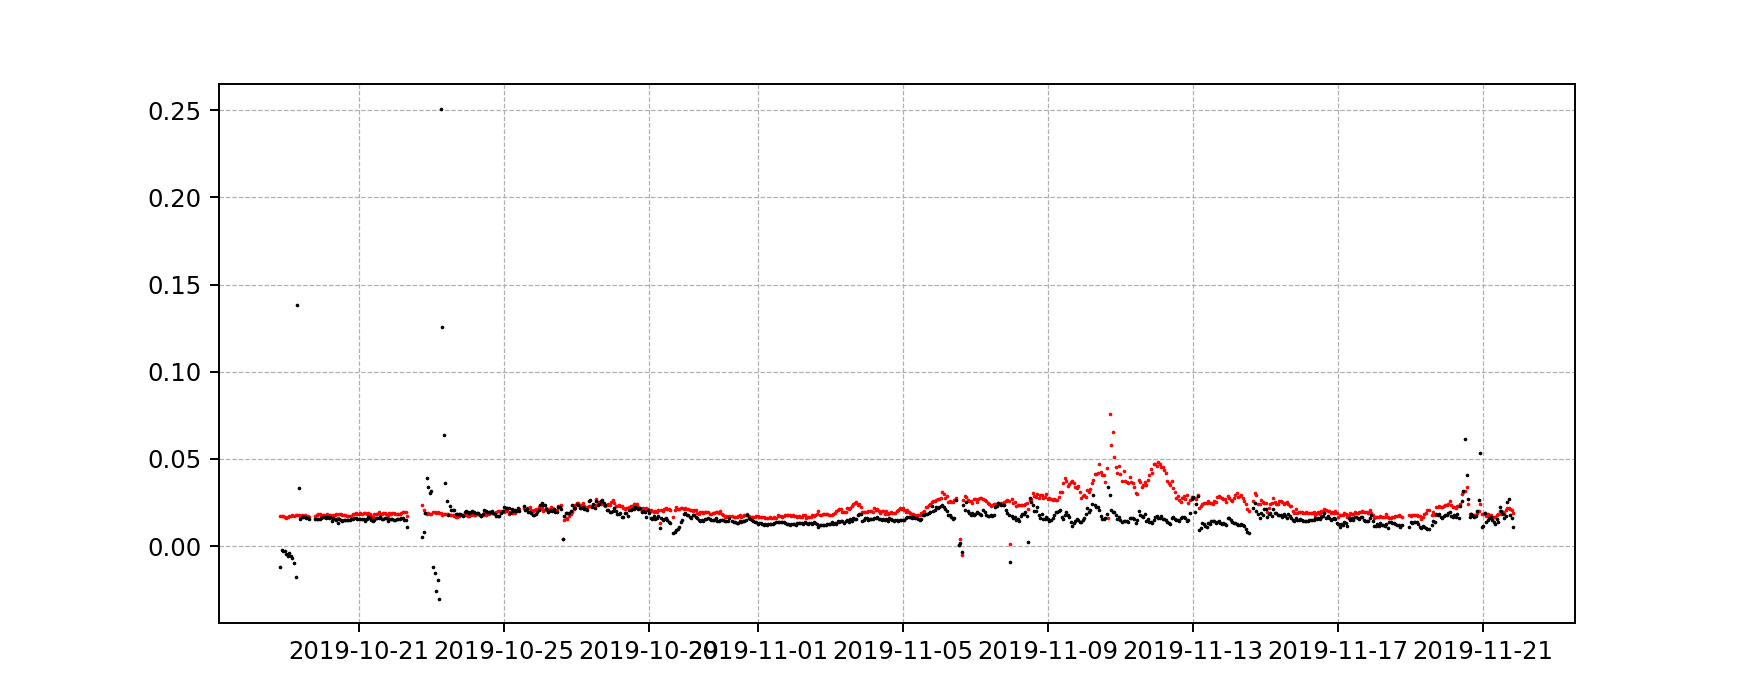

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 4))
# ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
ax.grid('on', ls='--', lw=0.5)

<IPython.core.display.Javascript object>


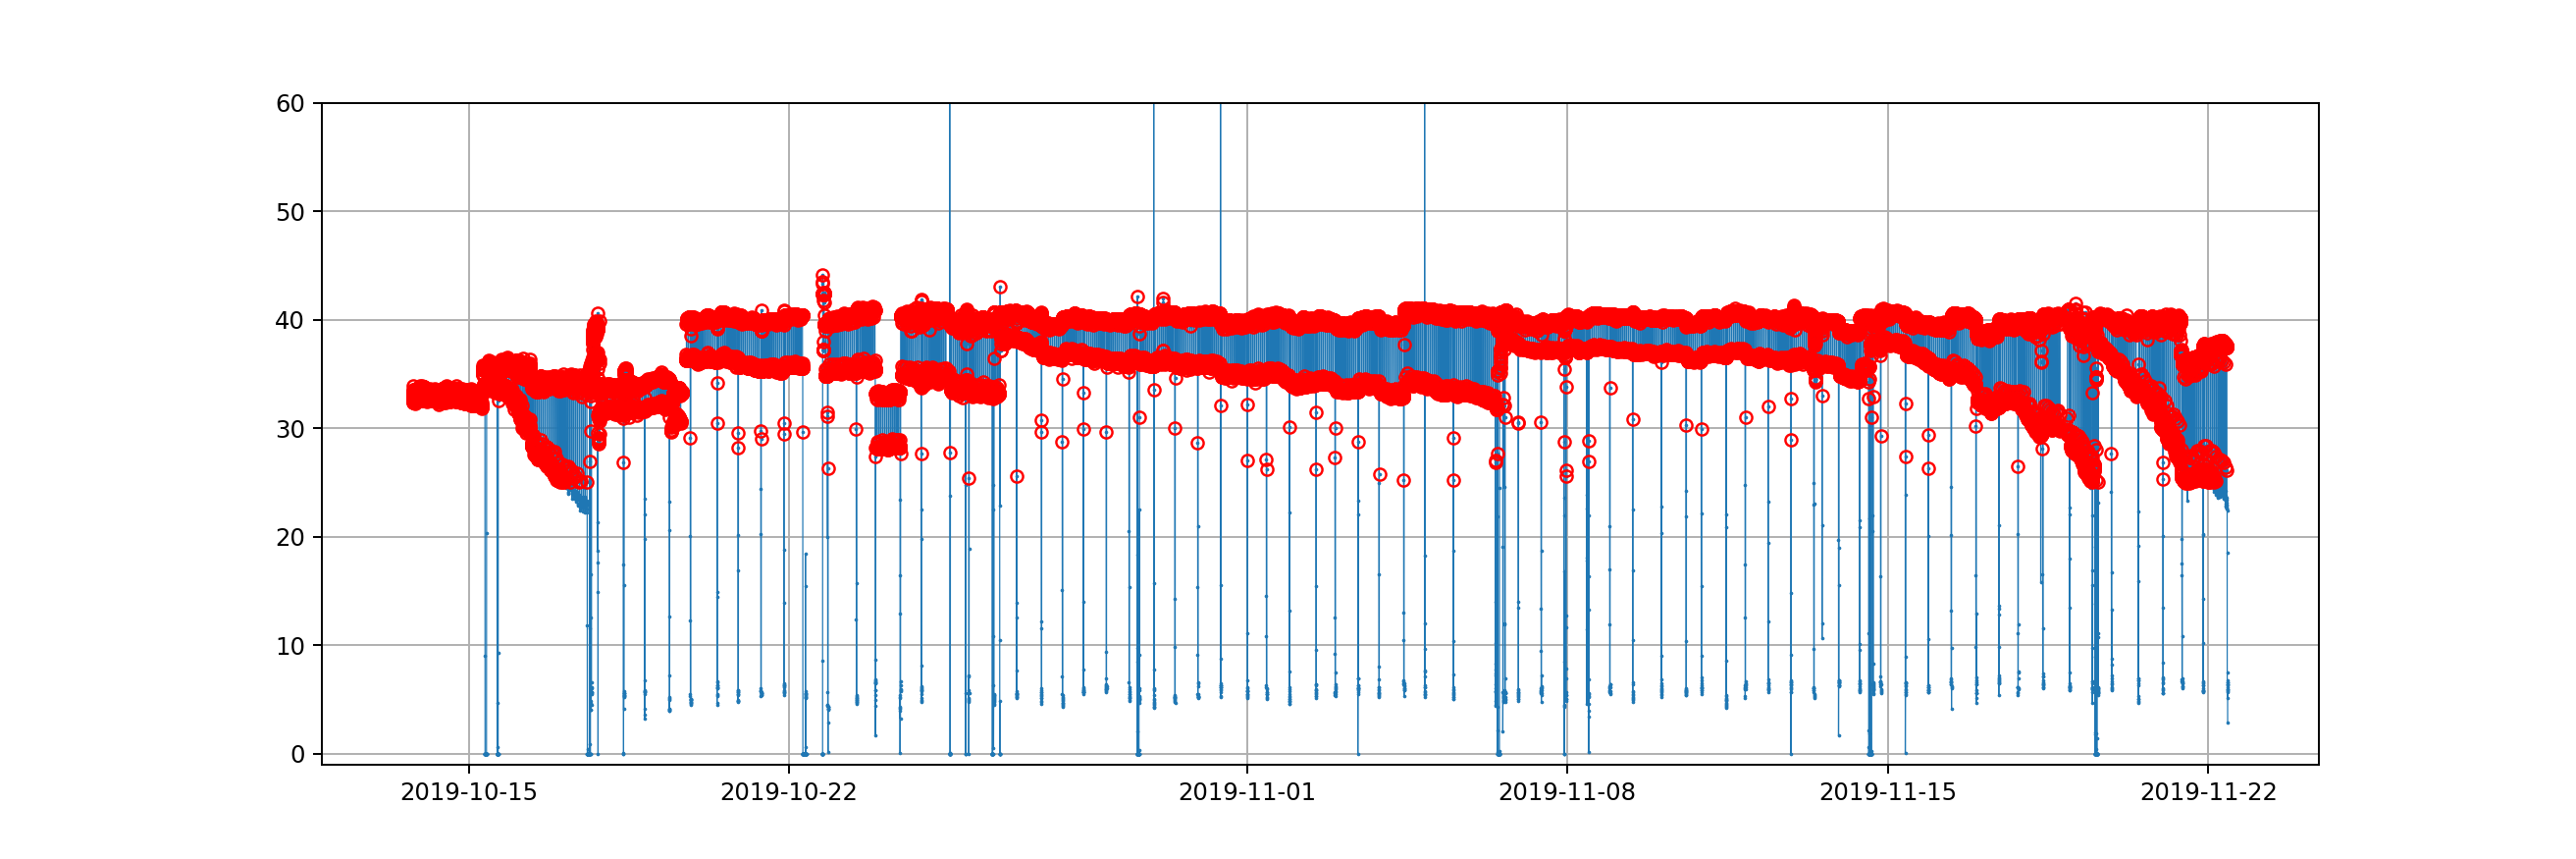

<IPython.core.display.Javascript object>


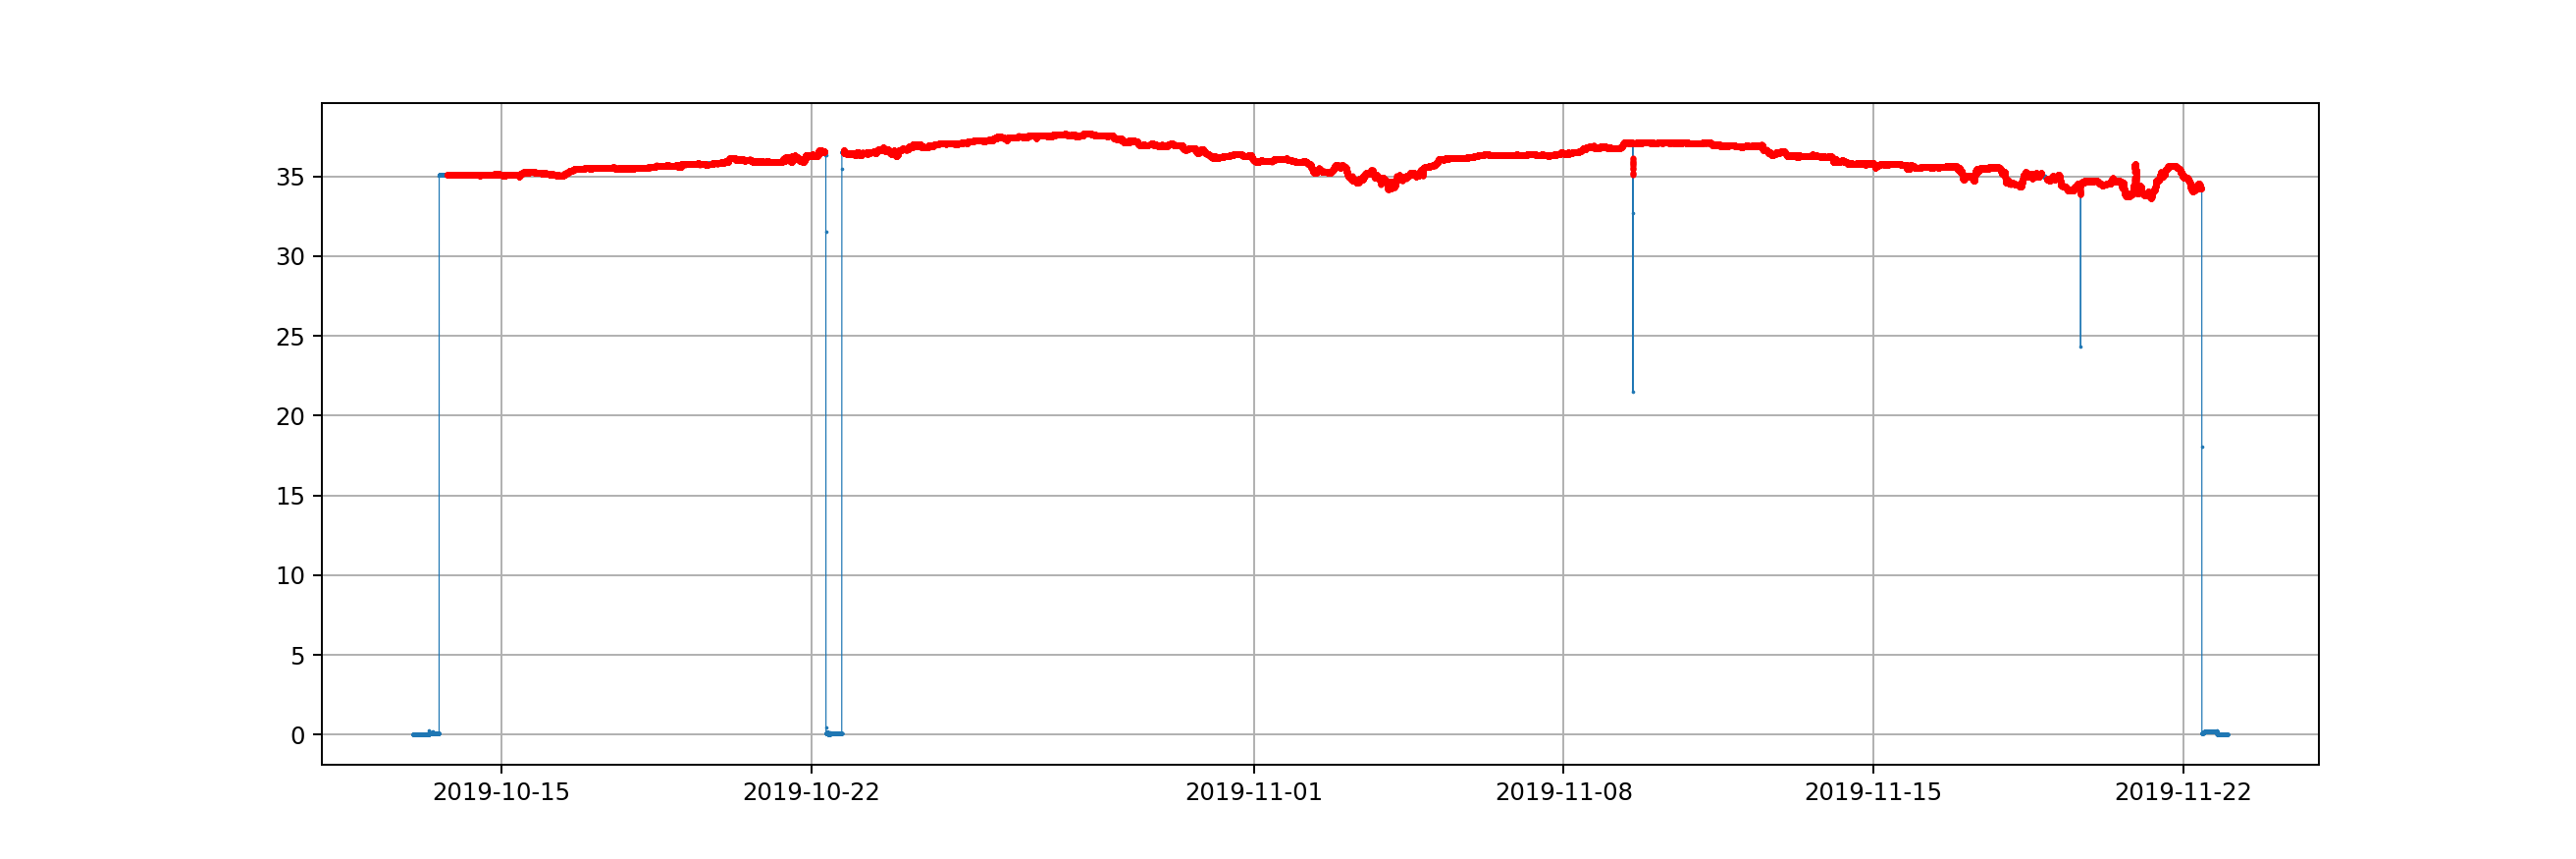

<IPython.core.display.Javascript object>


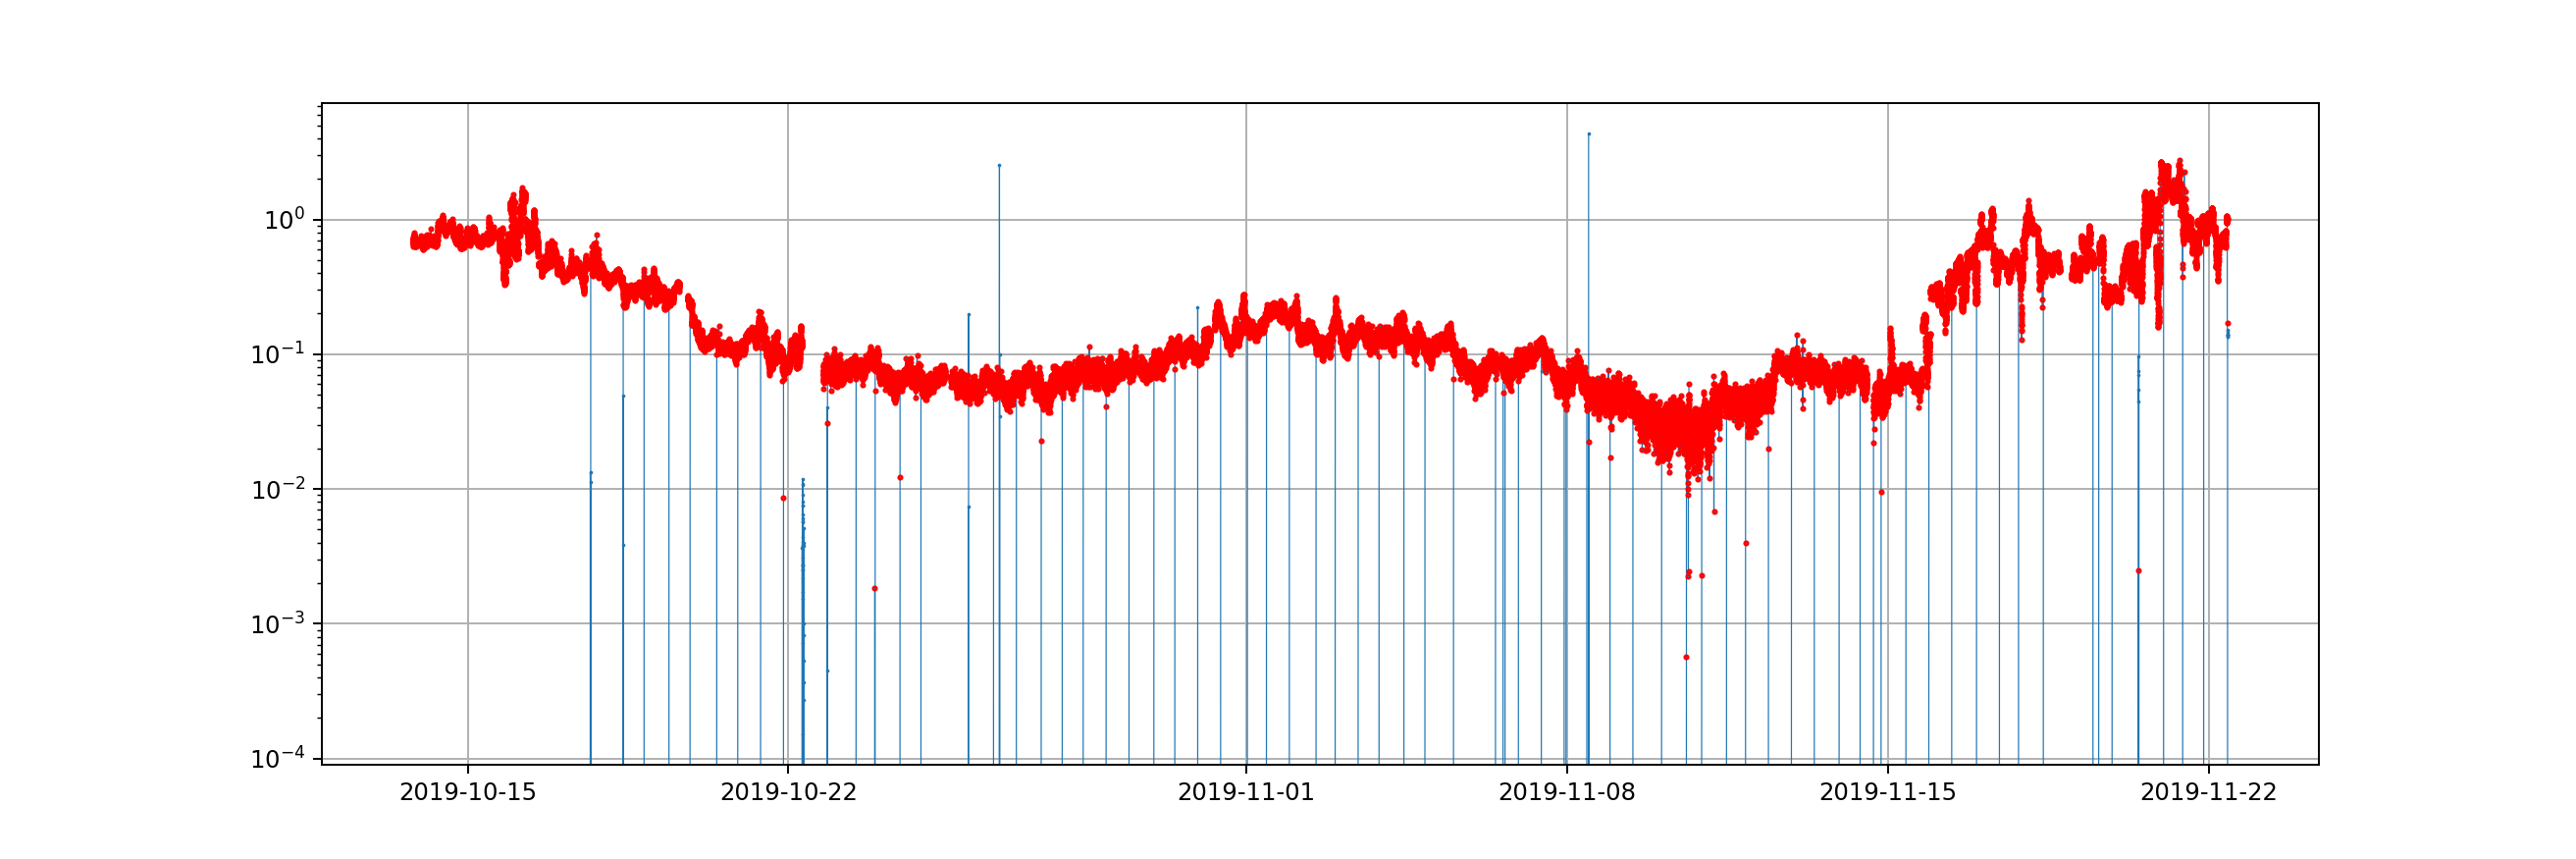

In [25]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f = np.where(  (acs.flow>MIN_FLOW_RATE) & (acs.uway_sal>MIN_SAL)   )[0]

fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(acs.time, acs.flow, '.-', lw=0.5, ms=1)
ax.plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none')
ax.grid('on')
plt.ylim([-1, 60])

fig0, ax0 = plt.subplots(1, figsize=(15, 5))
ax0.plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1)
ax0.plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none')
ax0.grid('on')

fig2, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1)
ax2.semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none')
ax2.grid('on')
# plt.ylim([1e-6, 10])


<IPython.core.display.Javascript object>


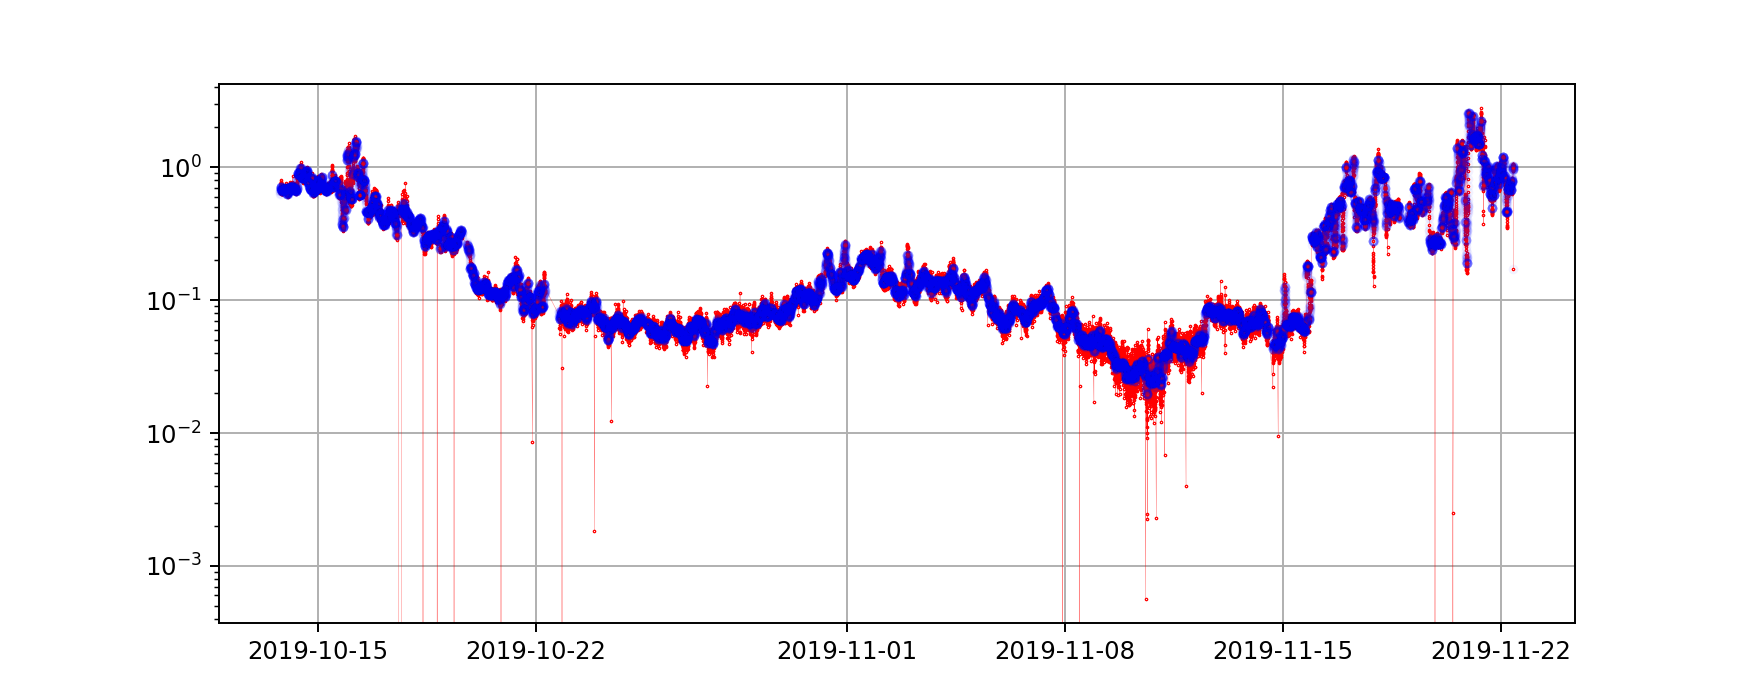

In [26]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(10, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
ax2.grid('on')
# plt.ylim([1e-6, 10])


In [27]:
# ds_acs

In [28]:
# df_hplc_surf

In [29]:
# # merge HPCL and ACS data
# # see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate

# # create pandas series with HPLC Tot_Chl_a data
# ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

# # averages duplicate values
# ds_hplc_surf = ds_hplc_surf.groupby('date').mean() 

# # create pandas series with medfilt ACS data
# df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])


# df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})

# df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
# df_hplc_acs

In [30]:
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
df_hplc_surf = df_hplc_surf.groupby('time').mean() 

# create pandas series with medfilt ACS data
df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf.Tot_Chl_a, 'acs_chl': df_acs})

df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf.index)
    
# df_hplc_acs

In [31]:
# df_hplc_surf

In [32]:
# compute residuals and stats
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1

delta = np.nanmedian(rres)
sigma = prcrng(rres)
N = len(rres)

print(delta, sigma, N)

-0.044008227421391655 0.09901238382936961 151


<IPython.core.display.Javascript object>


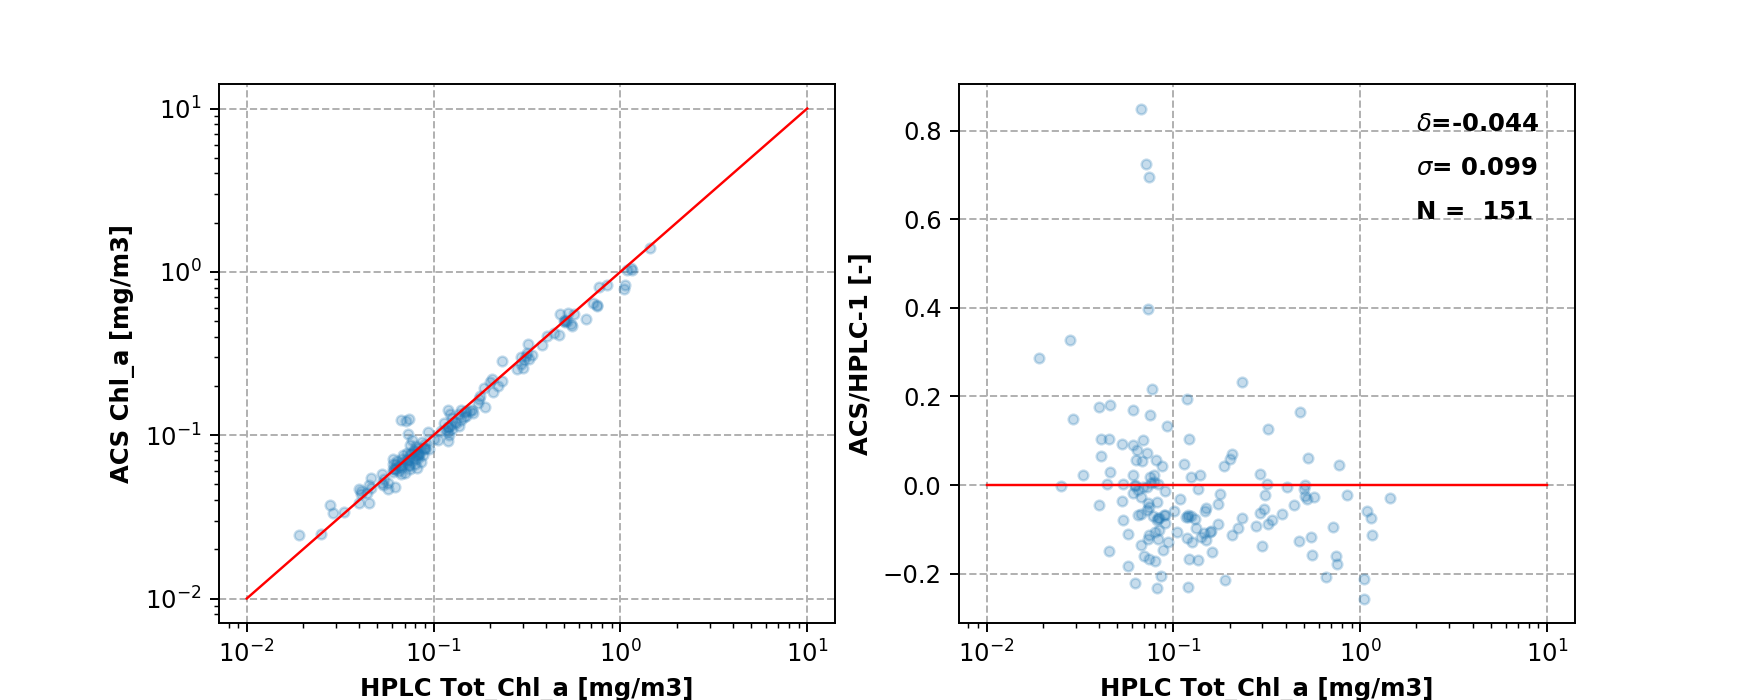

Text(2, 0.6, 'N =  151')

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [34]:
# find dates of large rres
r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(r>0.4)[0]
print(r[ii])
iss = 2
[df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acs_chl[ii][iss]]

time
2019-10-20 04:38:00    0.724447
2019-11-03 05:25:00    0.849977
2019-11-03 07:36:00    0.695788
dtype: float64


[0.074, 0.12548833293402611]

In [35]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [36]:
# fit data to power law
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acs_chl.values, df_hplc_acs.Tot_Chl_a.values)

perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )


chl_HPLC = a * chl_ACS^b 
a = 84.6 +/- 5.2
b = 1.020 +/- 0.013


In [37]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [38]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [39]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_long[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])
acs_out.index.rename('date_time [UTC]', inplace = True)



In [40]:
# add attributes to acs_chl_debiased
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_deiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


In [41]:
acs

<xarray.Dataset>
Dimensions:                                     (bb3wv: 3, hplc_time: 247, time: 59380, wv: 176)
Coordinates:
  * time                                        (time) datetime64[ns] 2019-10...
  * wv                                          (wv) float64 400.0 ... 750.0
  * bb3wv                                       (bb3wv) float64 470.0 ... 700.0
  * hplc_time                                   (hplc_time) datetime64[ns] 20...
Data variables: (12/104)
    flow                                        (time) float64 nan nan ... nan
    acs_chl                                     (time) float64 nan nan ... nan
    acs_ap                                      (time, wv) float64 ...
    acs_ap_u                                    (time, wv) float64 ...
    acs_bp                                      (time, wv) float64 ...
    acs_bp_u                                    (time, wv) float64 ...
    ...                                          ...
    hplc_Tchl_Tcar                              (hplc_time) float64 2.56 ... 1.6
    hplc_PPC_Tpg                                (hplc_time) float64 0.05 ... ...
    hplc_PSP_Tpg                                (hplc_time) float64 0.95 ... ...
    hplc_Tchl_a_Tpg                             (hplc_time) float64 0.57 ... ...
    hplc_comments                               (hplc_time) <U33 'nan' ... 'nan'
    acs_chl_debiased                            (time) float64 nan nan ... nan

In [42]:
# create new filtered acs dataframe
acs2 = acs.reset_index('time') # this is needed only for AMT29

# i2kp = np.where(  (acs.acs_ap[i2f,10][innan]>0) | (np.isreal(acs.ay440))  )[0]         # this removes ay data
i2kp = np.where(  (acs2.acs_ap[:,10]>0) | (acs2.ay440>0)  ) [0]
# i2kp = np.where(  acs.acs_ap[i2f,10][innan]>0  )[0]         # this removes ay data
# ix = xr.DataArray(acs.time[i2f][innan][i2kp], dims=['time'])
ix = xr.DataArray(acs2.time[i2kp], dims=['time'])
acs_filtered = acs2.sel(time=ix)

In [43]:
acs_filtered

<xarray.Dataset>
Dimensions:                                     (bb3wv: 3, hplc_time: 247, time: 43556, wv: 176)
Coordinates:
  * wv                                          (wv) float64 400.0 ... 750.0
  * bb3wv                                       (bb3wv) float64 470.0 ... 700.0
  * hplc_time                                   (hplc_time) datetime64[ns] 20...
    time_                                       (time) datetime64[ns] 2019-10...
Dimensions without coordinates: time
Data variables: (12/104)
    flow                                        (time) float64 33.13 ... 7.507
    acs_chl                                     (time) float64 0.6795 ... 0.1523
    acs_ap                                      (time, wv) float64 ...
    acs_ap_u                                    (time, wv) float64 ...
    acs_bp                                      (time, wv) float64 ...
    acs_bp_u                                    (time, wv) float64 ...
    ...                                          ...
    hplc_Tchl_Tcar                              (hplc_time) float64 2.56 ... 1.6
    hplc_PPC_Tpg                                (hplc_time) float64 0.05 ... ...
    hplc_PSP_Tpg                                (hplc_time) float64 0.95 ... ...
    hplc_Tchl_a_Tpg                             (hplc_time) float64 0.57 ... ...
    hplc_comments                               (hplc_time) <U33 'nan' ... 'nan'
    acs_chl_debiased                            (time) float64 0.7094 ... 0.159

<IPython.core.display.Javascript object>


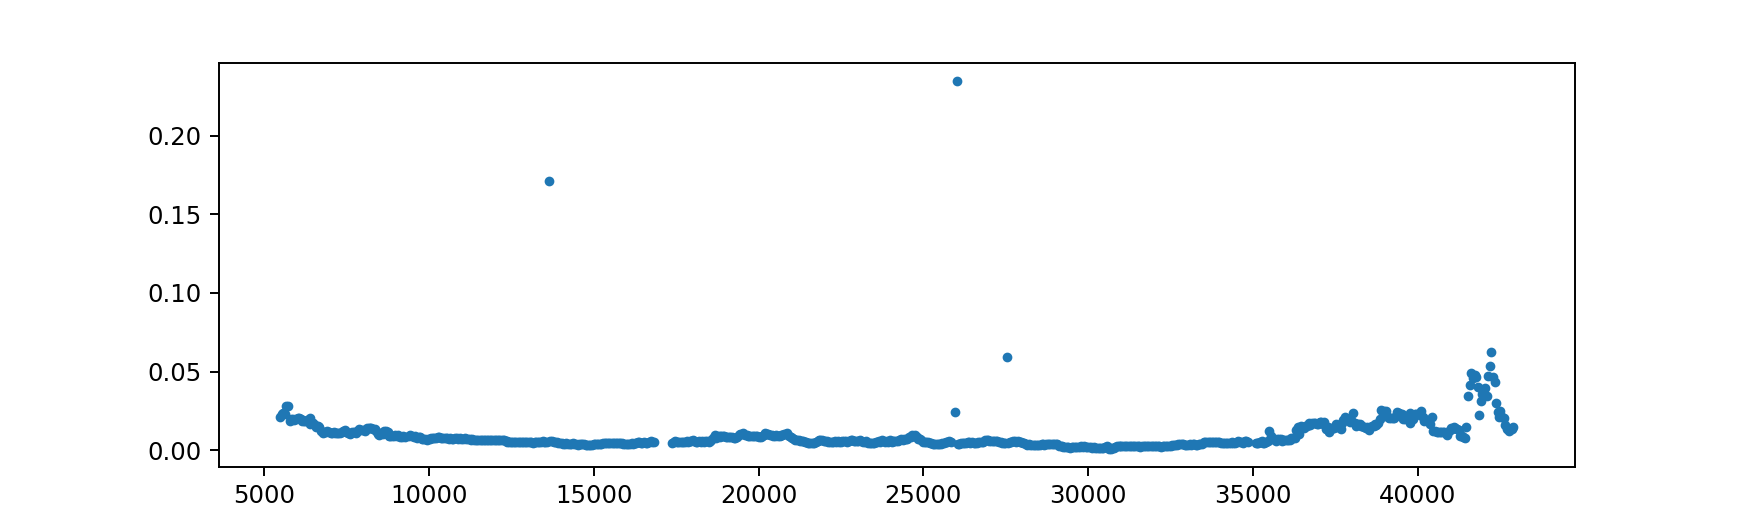

In [44]:
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(acs_filtered.ay440, '.')

In [45]:
# more filtering based on abs residuals that are greater than 3X the std of rres
iwv = 10
x = acs_filtered.acs_ap[:,iwv]
# x_rres = x/sg.medfilt(x, 51)-1
# ix2kp = np.where(abs(x_rres)<3*prcrng(x_rres))[0]

# ix2 = xr.DataArray(acs_filtered.time[ix2kp], dims=['time'])
# acs_filtered2 = acs_filtered.sel(time=ix2)



In [46]:
acs_filtered2 = acs_filtered
acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )

<IPython.core.display.Javascript object>


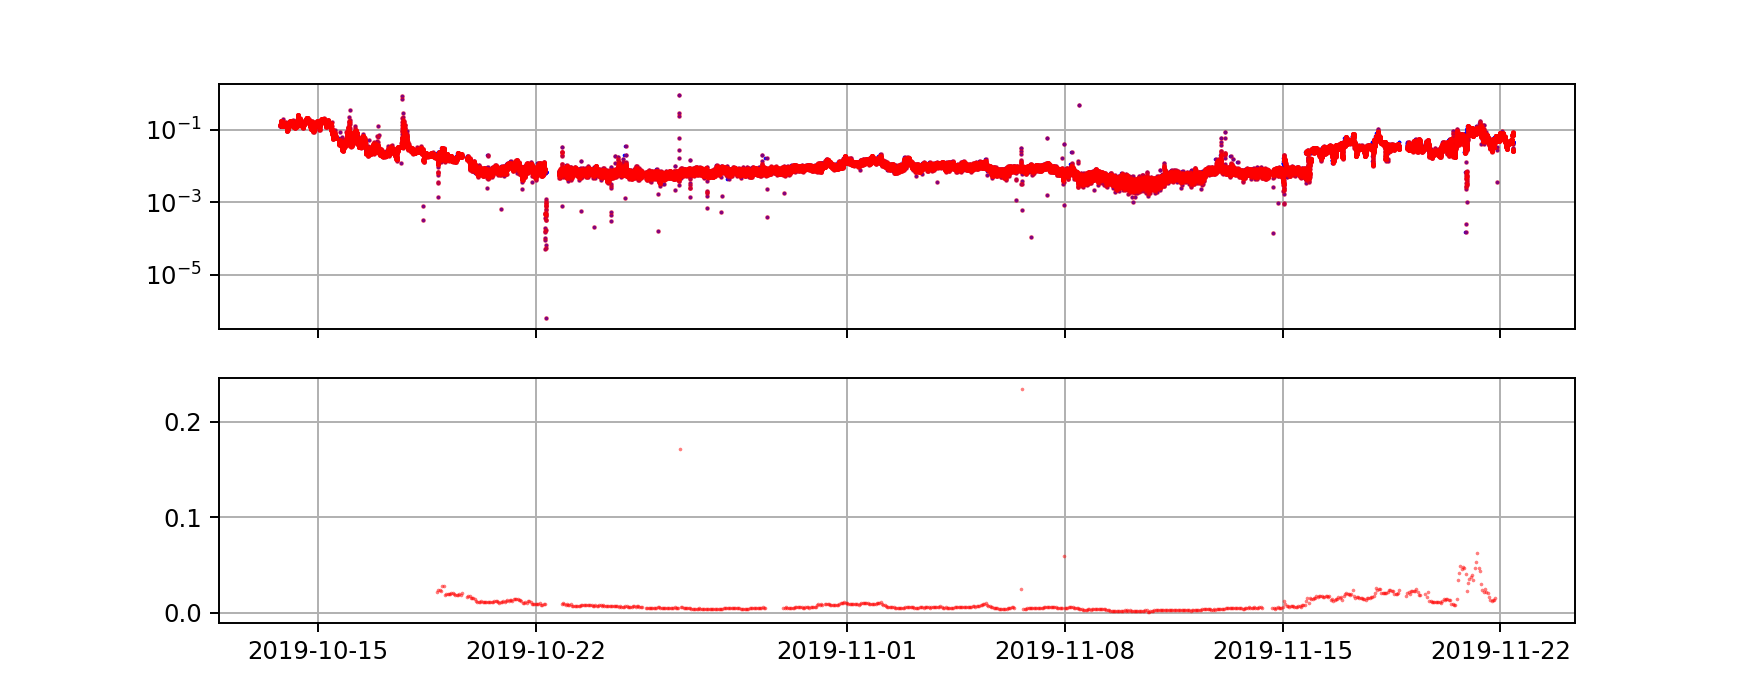

In [47]:
# plot to check                   
fig, [ax, ax2] = plt.subplots(2,1, figsize=(10, 4), sharex=True)

ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
ax.grid('on')

ax2.plot(acs_filtered2.time, acs_filtered2.ay440, 'r.', ms=1, alpha=0.5)
ax2.grid('on')


In [48]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
acs_filtered2

<xarray.Dataset>
Dimensions:                                     (bb3wv: 3, hplc_time: 247, time: 43556, wv: 176)
Coordinates:
  * wv                                          (wv) float64 400.0 ... 750.0
  * bb3wv                                       (bb3wv) float64 470.0 ... 700.0
  * hplc_time                                   (hplc_time) datetime64[ns] 20...
  * time                                        (time) datetime64[ns] 2019-10...
Data variables: (12/104)
    flow                                        (time) float64 33.13 ... 7.507
    acs_chl                                     (time) float64 0.6795 ... 0.1523
    acs_ap                                      (time, wv) float64 ...
    acs_ap_u                                    (time, wv) float64 ...
    acs_bp                                      (time, wv) float64 ...
    acs_bp_u                                    (time, wv) float64 ...
    ...                                          ...
    hplc_Tchl_Tcar                              (hplc_time) float64 2.56 ... 1.6
    hplc_PPC_Tpg                                (hplc_time) float64 0.05 ... ...
    hplc_PSP_Tpg                                (hplc_time) float64 0.95 ... ...
    hplc_Tchl_a_Tpg                             (hplc_time) float64 0.57 ... ...
    hplc_comments                               (hplc_time) <U33 'nan' ... 'nan'
    acs_chl_debiased                            (time) float64 0.7094 ... 0.159

In [49]:
acs_filtered2

<xarray.Dataset>
Dimensions:                                     (bb3wv: 3, hplc_time: 247, time: 43556, wv: 176)
Coordinates:
  * wv                                          (wv) float64 400.0 ... 750.0
  * bb3wv                                       (bb3wv) float64 470.0 ... 700.0
  * hplc_time                                   (hplc_time) datetime64[ns] 20...
  * time                                        (time) datetime64[ns] 2019-10...
Data variables: (12/104)
    flow                                        (time) float64 33.13 ... 7.507
    acs_chl                                     (time) float64 0.6795 ... 0.1523
    acs_ap                                      (time, wv) float64 ...
    acs_ap_u                                    (time, wv) float64 ...
    acs_bp                                      (time, wv) float64 ...
    acs_bp_u                                    (time, wv) float64 ...
    ...                                          ...
    hplc_Tchl_Tcar                              (hplc_time) float64 2.56 ... 1.6
    hplc_PPC_Tpg                                (hplc_time) float64 0.05 ... ...
    hplc_PSP_Tpg                                (hplc_time) float64 0.95 ... ...
    hplc_Tchl_a_Tpg                             (hplc_time) float64 0.57 ... ...
    hplc_comments                               (hplc_time) <U33 'nan' ... 'nan'
    acs_chl_debiased                            (time) float64 0.7094 ... 0.159

In [50]:
# save updated NetCDF file

acs_filtered2.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
acs_filtered2.close()